Success!
Success!


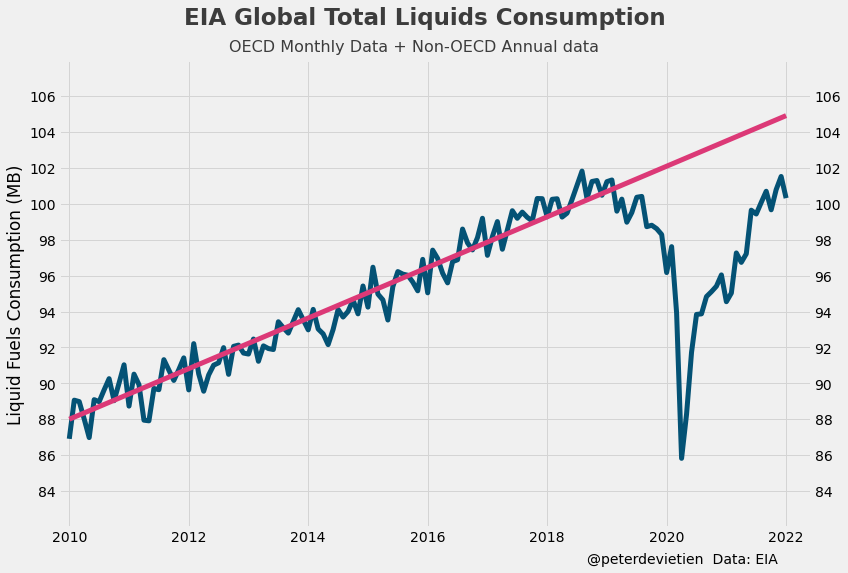

In [20]:
#Import libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import matplotlib.ticker as ticker




# API Key from EIA
api_key = '4Cgy5BurMNMAhbo0RBIu3s5FFyyo37QEVmW0uBoz'
# PADD Names to Label Columns
# Change to whatever column labels you want to use.
SERIES_NAMES = ['NON-OECD CONSUMPTION','OECD CONSUMPTION']
# Enter all your Series IDs here separated by commas
SERIES_KEY = ['IEO.2021.REFERENCE.CNSM_LIQP_NNN_MBPD.A','STEO.PATC_OECD.M']
# Initialize list - this is the final list that you will store all the data from the json pull. Then you will use this list to concat into a pandas dataframe. 
final_data = []
# Choose start and end dates
startDate = '2010-01-01'
endDate = '2022-01-01'


# Pull in data via EIA API
for i in range(len(SERIES_KEY)):
    url = 'http://api.eia.gov/series/?api_key=' + api_key + '&series_id=' + SERIES_KEY[i]
    r = requests.get(url)
    json_data = r.json()
    
    if r.status_code == 200:
        print('Success!')
    else:
        print('Error')
    
    df = pd.DataFrame(json_data.get('series')[0].get('data'),
                      columns = ['Date', SERIES_NAMES[i]])
    df.set_index('Date', drop=True, inplace=True)
    final_data.append(df)


final_data[0]['Year']=final_data[0].index.astype(str)
final_data[0]['Month']='1'
final_data[0]['Day']='1'
final_data[0]['Date'] = pd.to_datetime(final_data[0][['Year','Month','Day']])
final_data[0].set_index('Date',drop=True,inplace=True)
final_data[0].sort_index(inplace=True)
final_data[0] = final_data[0][startDate:endDate]
final_data[0] = final_data[0].iloc[:,:5]


final_data[1]['Year']=final_data[1].index.astype(str).str[:4]
final_data[1]['Month']=final_data[1].index.astype(str).str[4:]
final_data[1]['Day']='1'
final_data[1]['Date'] = pd.to_datetime(final_data[1][['Year','Month','Day']])
final_data[1].set_index('Date',drop=True,inplace=True)
final_data[1].sort_index(inplace=True)
final_data[1] = final_data[1][startDate:endDate]
final_data[1] = final_data[1].iloc[:,:5]

## Piecewise linear interpolation for NON-OECD data
plyear=[]
plmonth=[]
plday=[]
plcons=[]
pldates=[]

pldate0=final_data[1].index[0]
pldatef=final_data[1].index[-1]

pldate=pldate0

while pldate <= pldatef:
    #print(pldate)
    #print(pldate.year)
    #print(pldate.month)
    year0=pldate.year
    yearf=year0 + 1
    ind0=final_data[0]['Year']==str(year0)
    indf=final_data[0]['Year']==str(yearf)
    cons0=final_data[0]['NON-OECD CONSUMPTION'][ind0]
    consf=final_data[0]['NON-OECD CONSUMPTION'][indf]
    consmonthly=np.linspace(cons0,consf,13)
    #print(cons0)
    #print(consf)
    #print(consmonthly[pldate.month-1])
    #print(consmonthly)

    plyear.append(str(pldate.year))
    plmonth.append(str(pldate.month))
    plday.append('1')
    if pldate < pldatef:
        plcons.append(consmonthly[pldate.month-1][0])
    else:
        plcons.append(cons0[0])

    pldates.append(pldate)
    pldate = pldate + relativedelta(months=1)

#print(plconslist)

final_data.append(final_data[1].copy())

final_data[2].rename(columns={"OECD CONSUMPTION":"WORLD CONSUMPTION"},inplace=True)
final_data[2]['WORLD CONSUMPTION'] = plcons + final_data[1]['OECD CONSUMPTION']
final_data[2]['Year']=plyear
final_data[2]['Month']=plmonth
final_data[2]['Day']=plday
final_data[2]['Date'] = pd.to_datetime(final_data[2][['Year','Month','Day']])
final_data[2].set_index('Date',drop=True,inplace=True)
final_data[2].sort_index(inplace=True)
final_data[2] = final_data[2].iloc[:,:5]

final_data[0]=final_data[2].copy()
del final_data[2]




## Add trend line
datet0='2010-01-01'
datetf='2018-01-01'
indt0=final_data[0].index==datet0
indtf=final_data[0].index==datetf
const0=[88]#final_data[0]['WORLD CONSUMPTION'][indt0]
constf=final_data[0]['WORLD CONSUMPTION'][indtf]

dobj0=datetime.strptime(datet0,'%Y-%m-%d')
dobjf=datetime.strptime(datetf,'%Y-%m-%d')
diff = relativedelta(dobjf,dobj0)
dmonths=diff.months + diff.years*12
#print(dmonths)

m=(constf[0]-const0[0])/dmonths
b=const0[0]
x=final_data[0].index
#print(x)
#print(len(x))
#print(m)
y=range(len(x))*m + b
#print(y)
#print(len(final_data[0]))



final_data[1].rename(columns={"OECD CONSUMPTION":"TREND"},inplace=True)
final_data[1]['TREND'] = y



crude = pd.concat(final_data,axis=1)


# Generating Colours and Style
colors = {'NON-OECD CONSUMPTION':'#045275','TODAYS LEVEL':'#DC3977'}
plt.style.use('fivethirtyeight')


# Creating the Visualization
plot = crude.plot(figsize=(12,8), 
                  color=list(colors.values()), 
                  linewidth=5, 
                  legend=False)



plot.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plot.grid(color='#d4d4d4')
plot.set_ylabel('Liquid Fuels Consumption (MB)')
plot.set_yticks(range(84,108,2))
plot.set_ylim([82,108])
plot.tick_params(labelright=True)

xdates=[d.strftime('%Y') for d in pd.date_range(start="2010-01-01",end="2022-01-01",periods=7)]
plot.set_xticks(xdates)
plot.set_xticklabels(xdates)
plot.set_xlim([date(2009,11,1),date(2022,6,1)])
plot.set_xlabel('')
#plot.legend({'OECD + non-OECD'},fontsize=22,loc='bottom right')
plot.text(x = crude.index[23], 
          y = 110, 
          s = "EIA Global Total Liquids Consumption", 
          fontsize = 23, 
          weight = 'bold', 
          alpha = .75)
plot.text(x = crude.index[32], 
          y = 108.5, 
          s = "OECD Monthly Data + Non-OECD Annual data", 
          fontsize = 16, 
          alpha = .75)
plot.text(x = date(2018,9,1), 
          y = 80,
          s = '@peterdevietien  Data: EIA', 
          fontsize = 14)

pngname='total_consumption_world'
plt.savefig('/Users/peter/projects/oil/post/'+pngname)


In [ ]:

#final_data[0]['WORLD CONSUMPTION'][0]
#indf=final_data[0]['Date']==str(datetf)